In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [237]:
import pandas as pd
import numpy as np


# Read all data and set hn as index

In [238]:
df = pd.read_csv('https://raw.githubusercontent.com/plenoi/Clinic/master/ultima_all_clean.csv')
df = df.set_index('hn')
df.head()

,age,parity,hiv,menopaus,disease,surgery,conization,OPDsize,appearance,stage,...,nodeyiel,RHlvsi,depth,size,utmet,vgmargin,vgmet,pelvicme,pmmet,adnmet
hn,,,,,,,,,,,,,,,,,,,,,
2631840,52,3,0.0,0.0,1,1,0.0,5.0,4.0,5.0,...,21.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
2633481,32,2,0.0,0.0,0,1,0.0,5.0,1.0,5.0,...,11.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,2.0
2634477,52,2,0.0,0.0,0,0,0.0,5.0,NaN,5.0,...,35.0,6.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2633633,38,2,0.0,0.0,0,0,0.0,2.0,1.0,4.0,...,20.0,16.0,3.0,3.8,0.0,0.0,0.0,0.0,0.0,2.0
2630496,55,3,0.0,1.0,0,0,1.0,0.0,5.0,4.0,...,17.0,9.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Data Preprocessing
Check number of data

In [ ]:
df.shape

In [239]:
df.isnull().sum(axis=0)

age             0
parity          0
hiv             4
menopaus        1
disease         0
surgery         0
conization      5
OPDsize        17
appearance    101
stage          24
pchemo          1
Wardsize      145
finalhisto     10
nodeyiel       12
RHlvsi        366
depth         489
size          114
utmet          98
vgmargin       96
vgmet          97
pelvicme        1
pmmet          94
adnmet          7
dtype: int64

In [240]:
df_clean_column = df.drop(['appearance','Wardsize','RHlvsi','depth','nodeyiel','vgmargin','pelvicme','adnmet'],axis = 1)
df_clean_column.isnull().sum(axis=0)

age             0
parity          0
hiv             4
menopaus        1
disease         0
surgery         0
conization      5
OPDsize        17
stage          24
pchemo          1
finalhisto     10
size          114
utmet          98
vgmet          97
pmmet          94
dtype: int64

## Delete row with at least 1 missing data

In [241]:
df_clean = df_clean_column.dropna(axis = 0)

## Total Clean Data

In [242]:
df_clean.shape

(1555, 15)

## Check number of sample in pmmet class

In [243]:
pel_class = np.unique(df_clean['pmmet'])
pel_class

array([0., 1.])

In [244]:
pel_value = [sum(df_clean['pmmet']==pel_class[0]),
             sum(df_clean['pmmet']==pel_class[1])]
pel_value

[1278, 277]

## Separate pmmet dataset into data (X) and label (y)

In [245]:
y = df_clean['pmmet'].values
X = df_clean.drop(['pmmet'],axis = 1).values

## Separate Data into Train & Test (Note: Imbalance Dataset)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

## Data normalization to range of (0 to 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [ ]:
np.max(X_train_norm,0)

In [ ]:
np.max(X_test_norm,0)

# Logistic Regression
10-Folds Cross Validation Training Accuracy with Tuning

In [295]:
y = df_clean['pmmet'].values
X = df_clean.drop(['pmmet'],axis = 1).values

In [296]:
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import chi2
fs = GenericUnivariateSelect(chi2, mode='k_best', param=5)
X = fs.fit_transform(X, y)

In [297]:
from sklearn.model_selection import train_test_split
X, Xt, y, yt = train_test_split(X,y,test_size=0.2,random_state=0)

In [301]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
fs = SelectKBest(chi2, k=5)
fs.fit(X, y)
X = fs.transform(X)
Xt = fs.transform(Xt)

In [302]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)
X_train_norm = scaler.transform(X)
X_test_norm = scaler.transform(Xt)

In [303]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {'C': [1, 2, 4, 8, 16]}
clf = GridSearchCV(LogisticRegression(random_state=0, solver='liblinear'),params, cv=10)
clf.fit(X_train_norm, y)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'C': 2}
10CV accuracy : 83.12258064516129


## Test Accuracy

In [304]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
print("Test accuracy : "+str(sum(yt == y_predict)/len(yt)*100))

Test accuracy : 85.85209003215434


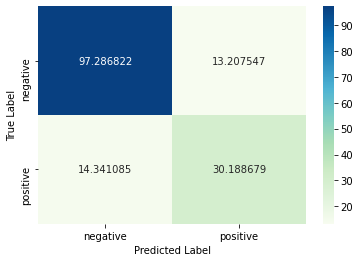

In [305]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(yt,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt="f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Random Forest

In [306]:
y = df_clean['pmmet'].values
X = df_clean.drop(['pmmet'],axis = 1).values

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=1)
X, y = sm.fit_resample(X, y)

from sklearn.model_selection import train_test_split
X, Xt, y, yt = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)
X = scaler.transform(X)
Xt = scaler.transform(Xt)

In [ ]:
#optionเสริม 
#GenericUnivariateSelect
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import chi2
fs = GenericUnivariateSelect(chi2, mode='k_best', param=5)
fs.fit(X, y)
X = fs.transform(X)
Xt = fs.transform(Xt)

#PCA
from sklearn.decomposition import PCA
fr = PCA(n_components=3)
fr.fit(X)
X = fr.transform(X)
Xt = fr.transform(Xt)

#SelectKbest
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
fs = SelectKBest(chi2, k=5)
fs.fit(X, y)
X = fs.transform(X)
Xt = fs.transform(Xt)

In [307]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators' : [10,50,100],
    'min_samples_leaf' : [1,8,32],
    'max_features' : ['sqrt',0.5,0.8],
    'criterion' : ['gini','entropy']
}
clf = GridSearchCV(RandomForestClassifier(random_state=0),params, cv = 10)
clf.fit(X,y)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
10CV accuracy : 91.29124820659969


In [308]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(Xt)
target_names = ['negative', 'positive']
sum(yt == y_predict)/len(yt)

0.90625

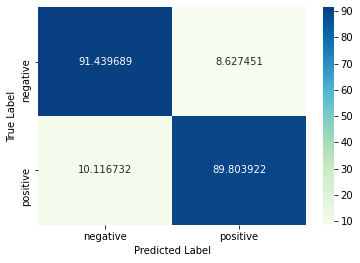

In [309]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(yt,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt="f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [311]:
print(classification_report(yt, y_predict, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.90      0.91      0.91       257
    positive       0.91      0.90      0.91       255

    accuracy                           0.91       512
   macro avg       0.91      0.91      0.91       512
weighted avg       0.91      0.91      0.91       512

